Image Classification using Convolutional Neural Networks

Author:
Maria Diana Mae Melencio

Objective:
This project aims to construct a Convolutional Neural Network (CNN) classification model leveraging the CIFAR-10 dataset. The primary goal is to train the model to effectively categorize images depicting various objects into one of the ten predetermined classes.

Introduction:
Image classification stands as a fundamental task within computer vision, finding utility in a broad spectrum of applications from facial recognition to autonomous driving. The CIFAR-10 dataset serves as a widely adopted benchmark for image classification endeavors, encompassing 60,000 32x32 color images distributed across 10 distinct classes. These classes represent diverse objects including airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

The dataset is partitioned into 50,000 training images and 10,000 testing images, ensuring an equitable distribution of images across each class. This balanced distribution renders CIFAR-10 well-suited for both training and assessing machine learning models.

This project entails the development of a CNN model utilizing TensorFlow and Keras frameworks to classify images from the CIFAR-10 dataset. The model will undergo training on the training set and subsequent evaluation on the test set, facilitating an assessment of its performance in terms of accuracy and pertinent metrics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model
from tensorflow.keras.models import Sequential

Data Pre-processing

In [2]:
# Load the batches.meta file
with open('batches.meta', 'rb') as f:
    meta = pickle.load(f)

# Access the keys in the meta dictionary
label_names = meta['label_names']
num_cases_per_batch = meta['num_cases_per_batch']
num_vis = meta['num_vis']

print("Label names:", label_names)
print("Number of cases per batch:", num_cases_per_batch)
print("Number of dimensions per image:", num_vis)

Label names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of cases per batch: 10000
Number of dimensions per image: 3072


In [3]:
def load_cifar10_batch(file_path):
    #Load a single batch of CIFAR-10 dataset.
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch

def load_cifar10_data(file_names):
    #Load CIFAR-10 dataset from multiple batches.
    data_batches = [load_cifar10_batch(f) for f in file_names]
    data = np.concatenate([batch[b'data'] for batch in data_batches], axis=0)
    labels = np.concatenate([batch[b'labels'] for batch in data_batches], axis=0)
    return data, labels

# File paths for CIFAR-10 dataset
data_batch_files = [
    'data_batch_1',
    'data_batch_2',
    'data_batch_3',
    'data_batch_4',
    'data_batch_5'
]
test_batch_file = 'test_batch'

In [4]:
# Load training and testing data
train_data, train_labels = load_cifar10_data(data_batch_files)
test_data, test_labels = load_cifar10_data([test_batch_file])

In [5]:
# Reshape the images from a flatten format (1D array) to a 3D array format and normalize the data
train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype(np.float32) / 255.0
test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype(np.float32) / 255.0

print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)
print("Testing data shape:", test_data.shape)
print("Testing labels shape:", test_labels.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000,)


In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.15,  # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15, # Randomly shift images vertically by up to 15% of the height
    shear_range=0.1,        # Apply random shear transformation
    zoom_range=0.2,         # Apply random zoom
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=False,    # No vertical flipping
    fill_mode='reflect'     # Fill in newly created pixels after rotation or shift with reflection
)

# Specify the batch size for generating augmented images
batch_size = 32

# Generate augmented images from the training set
augmented_data_generator = datagen.flow(train_data, train_labels, batch_size=batch_size)

EDA

Images shape: (50000, 32, 32, 3)
Labels shape: (50000,)
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


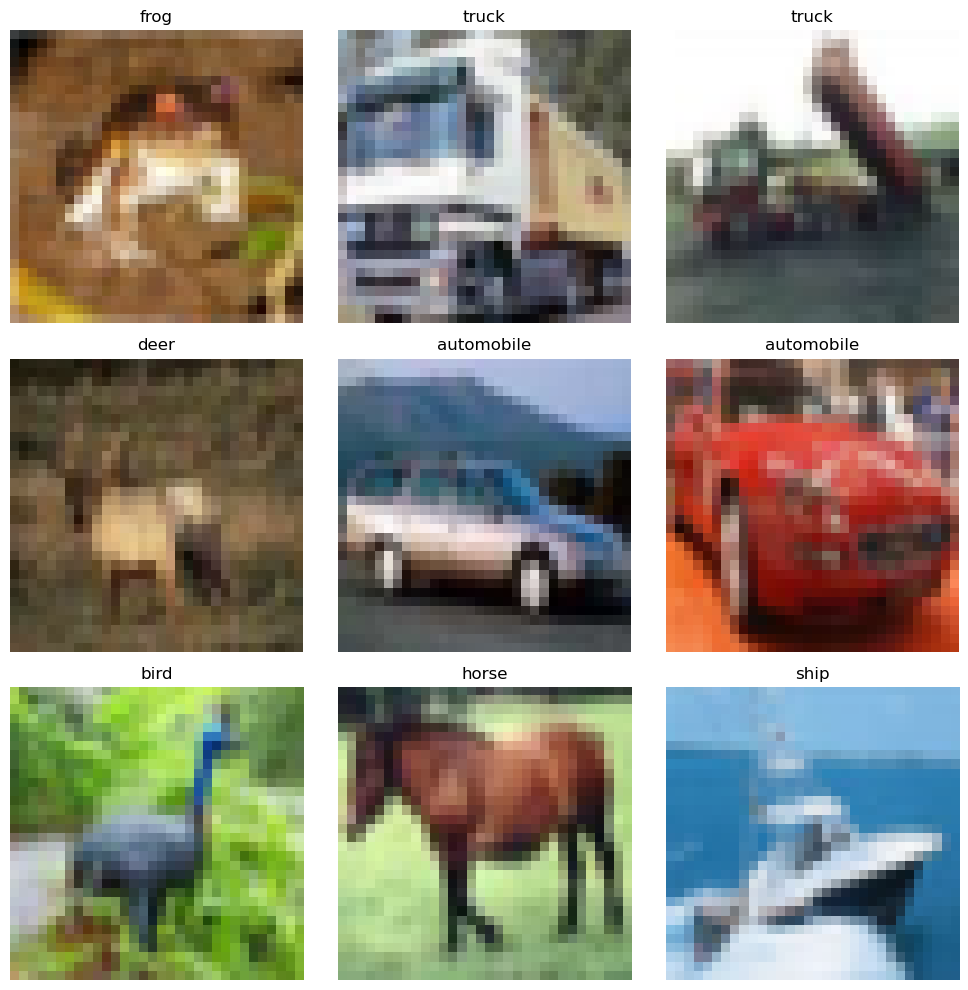

In [7]:
def plot_images(images, labels, class_names, num_images=9):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Class names:", class_names)
    
    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    
    # Flatten axes array
    axes = axes.flatten()
    
    # Loop over images and labels and plot them
    for i in range(num_images):
        # Plot image
        axes[i].imshow(images[i])
        
        # Set title as class name
        class_index = labels[i]
        if class_index >= len(class_names):  # Check if class_index is out of range
            print(f"Label index {class_index} is out of range for class_names list.")
            continue
        class_name = class_names[class_index]
        axes[i].set_title(class_name)
        
        # Remove axes
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot a grid of 9 images from the training set
plot_images(train_data, train_labels, label_names, num_images=9)

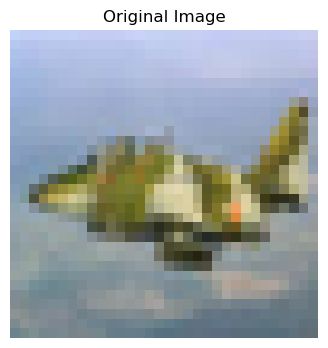

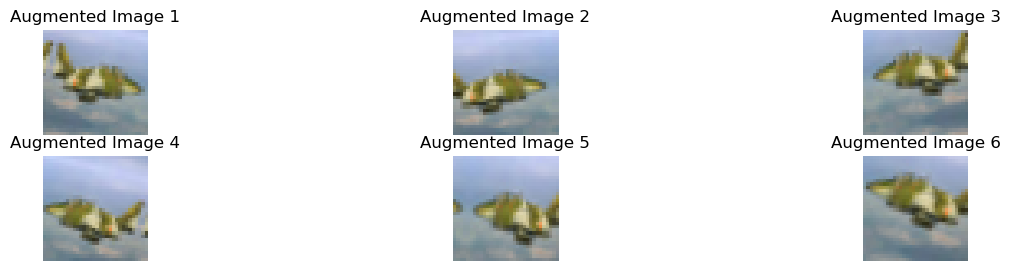

In [8]:
# Select a random image from the dataset
img_idx = np.random.randint(len(train_data))
original_img = train_data[img_idx]

# Reshape the image for plotting
original_img_plot = original_img.reshape((32, 32, 3))

# Plot the original image
plt.figure(figsize=(4, 4))
plt.imshow(original_img_plot)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Generate augmented images
augmented_images = []
num_augmented = 6  # Number of augmented images to generate
for img in datagen.flow(np.expand_dims(original_img, axis=0), batch_size=1):
    augmented_images.append(img.reshape((32, 32, 3)))
    if len(augmented_images) >= num_augmented:
        break

# Plot the augmented images
plt.figure(figsize=(15, 3))
for i, augmented_img in enumerate(augmented_images):
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_img)
    plt.title(f"Augmented Image {i+1}")
    plt.axis('off')
plt.show()

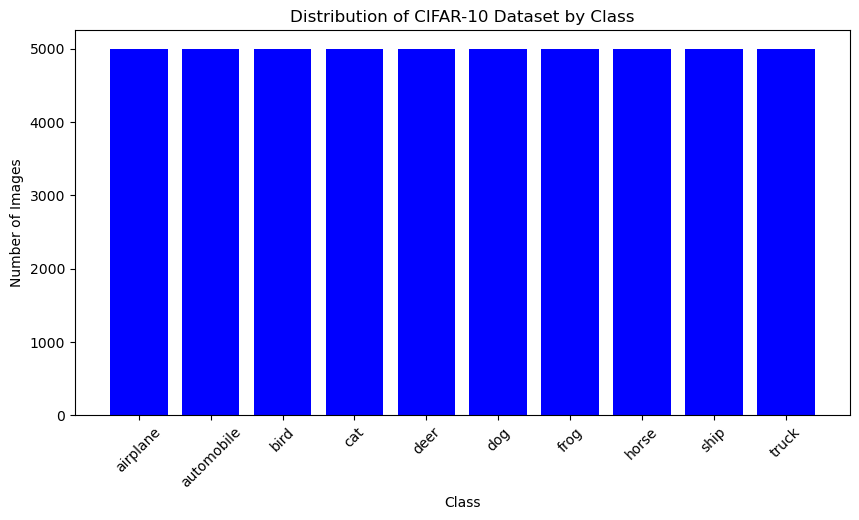

In [9]:
# Count the number of images in each class
class_counts = np.bincount(train_labels)

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the distribution of the data by class
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts, color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of CIFAR-10 Dataset by Class')
plt.xticks(rotation=45)
plt.show()

Model Building

In [10]:
from tensorflow.keras.models import Sequential

# Define input shape
input_shape = (32, 32, 3)

# Define number of classes
num_classes = 10

# Build the CNN model
model = Sequential([
    # Step 1: Convolutional Layer with ReLU activation function and Pooling
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Step 2: Convolutional Layer with ReLU activation function and Pooling
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Step 3: Convolutional Layer with ReLU activation function and Pooling
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Step 4: Flattening the pooled feature map
    Flatten(),
    
    # Step 5: Full Connection Layer (1 Hidden Layer)
    Dense(256, activation='relu'),
    
    # Step 6: Output Layer
    Dense(num_classes, activation='softmax')
])

# Step 7: Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 8: Print the model summary
model.summary()

C:\Users\mdmme\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,362 (2.37 MB)

 Trainable params: 620,362 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

Model Training - First Model

In [11]:
cnn_history = model.fit(x=augmented_data_generator,validation_data=(test_data, test_labels),epochs=20)

Epoch 1/20


C:\Users\mdmme\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - accuracy: 0.3340 - loss: 1.8066 - val_accuracy: 0.5098 - val_loss: 1.3888
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.5296 - loss: 1.3184 - val_accuracy: 0.6281 - val_loss: 1.0355
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.5792 - loss: 1.1742 - val_accuracy: 0.6578 - val_loss: 0.9873
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.6233 - loss: 1.0750 - val_accuracy: 0.7089 - val_loss: 0.8348
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.6446 - loss: 0.9998 - val_accuracy: 0.6975 - val_loss: 0.8820
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.6643 - loss: 0.9486 - val_accuracy: 0.7260 - val_loss: 0.7757
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.6784 - loss: 0.9104 - val_accuracy: 0.7176 - val_loss: 0.8111
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.6842 - loss: 0.89

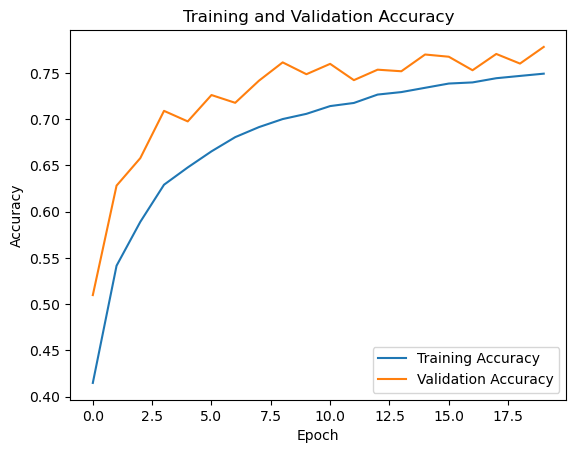

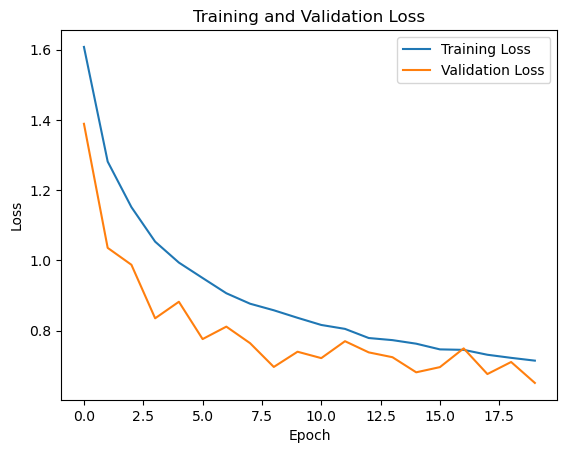

In [12]:
# Plot training and validation accuracy
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model Evaluation - First Model

In [13]:
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(train_data, train_labels)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)

# Print the training and test loss and accuracy
print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8105 - loss: 0.5322
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7816 - loss: 0.6458
Train Loss: 0.5346163511276245, Train Accuracy: 0.8089600205421448
Test Loss: 0.6508356332778931, Test Accuracy: 0.777999997138977


Observations:

The model performs significantly better than random guessing, as indicated by both training and test accuracies.
There is a slight overfitting issue as the training accuracy is higher than the test accuracy.
The model seems to generalize well as the test accuracy is relatively close to the training accuracy.
The loss values are decreasing, indicating that the model is learning from the training data.

In conclusion, the model shows decent performance on the CIFAR-10 dataset, with both training and test accuracies above 75%. However, further tuning or regularization techniques might be beneficial to improve generalization and reduce overfitting.

Model Training - Second Model

In [14]:
# Define input shape
input_shape = (32, 32, 3)

# Define number of classes
num_classes = 10

# Build the CNN model
model1 = Sequential([
    # Step 1: Convolutional Layer with ReLU activation function and Pooling
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    
    # Step 2: Convolutional Layer with ReLU activation function and Pooling
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Step 3: Convolutional Layer with ReLU activation function and Pooling
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Step 4: Flattening the pooled feature map
    Flatten(),
    
    # Step 5: Full Connection Layer (1 Hidden Layer)
    Dense(128, activation='relu'),
    
    # Step 6: Output Layer
    Dense(num_classes, activation='softmax')
])

# Step 7: Compile the model
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 8: Print the model summary
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,310,154 (5.00 MB)

 Trainable params: 1,310,154 (5.00 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Define the callbacks (Early-Stopping and Reduce Learning Rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0)

# Fit the model with callbacks
cnn1_history = model1.fit(
    x=augmented_data_generator,
    validation_data=(test_data, test_labels),
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 104s 65ms/step - accuracy: 0.3114 - loss: 1.8556 - val_accuracy: 0.5569 - val_loss: 1.2156 - learning_rate: 0.0010
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 101s 64ms/step - accuracy: 0.5199 - loss: 1.3274 - val_accuracy: 0.5879 - val_loss: 1.1331 - learning_rate: 0.0010
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 105s 67ms/step - accuracy: 0.5829 - loss: 1.1707 - val_accuracy: 0.6690 - val_loss: 0.9291 - learning_rate: 0.0010
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 103s 66ms/step - accuracy: 0.6250 - loss: 1.0680 - val_accuracy: 0.6714 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 101s 65ms/step - accuracy: 0.6484 - loss: 0.9991 - val_accuracy: 0.7012 - val_loss: 0.8707 - learning_rate: 0.0010
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 103s 65ms/step - accuracy: 0.6647 - loss: 0.9483 - val_accuracy: 0.7201 - val_loss: 0.8029 - learning_rate: 0.0010
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 102s 65ms/step -

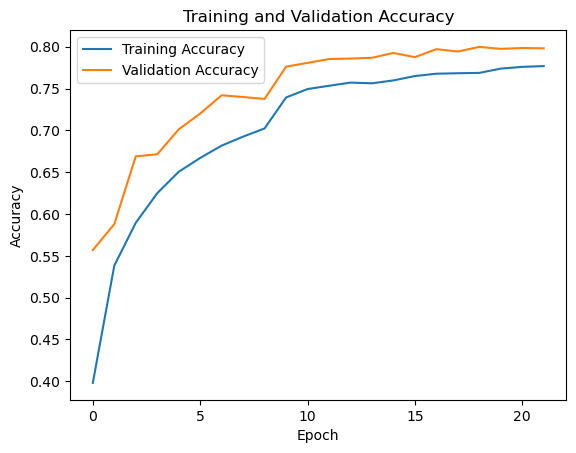

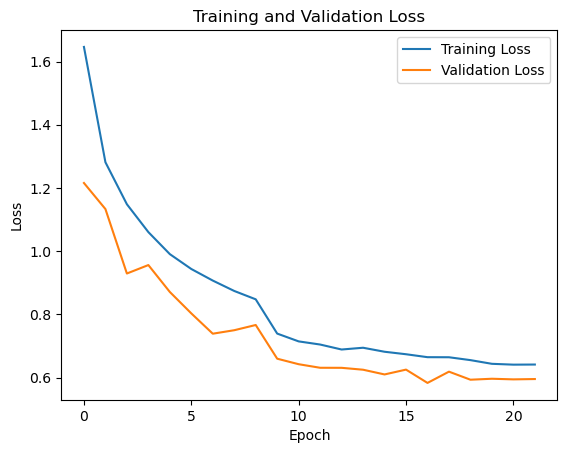

In [16]:
# Plot training and validation accuracy
plt.plot(cnn1_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn1_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(cnn1_history.history['loss'], label='Training Loss')
plt.plot(cnn1_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


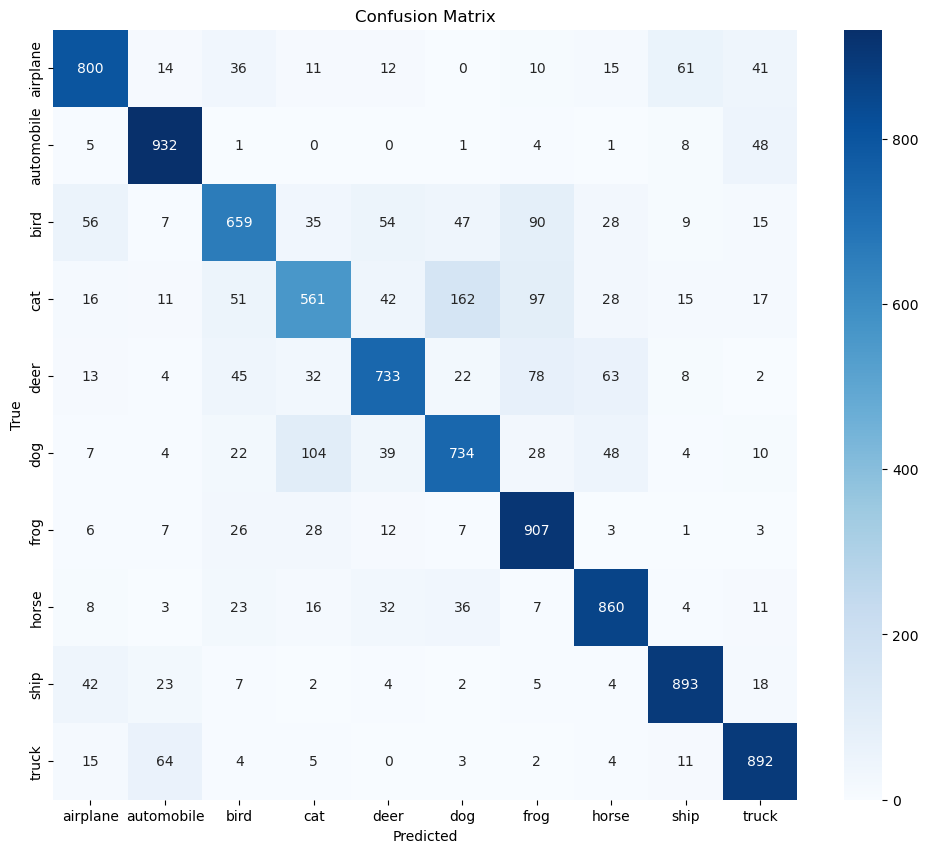

In [17]:
# Make predictions on the test set
predictions = model1.predict(test_data)

# Get the predicted labels for the test set
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Evaluate the model on the training set
train_loss, train_accuracy = model1.evaluate(train_data, train_labels)

# Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(test_data, test_labels)

# Print the training and test loss and accuracy
print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.8274 - loss: 0.4906
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7940 - loss: 0.5869
Train Loss: 0.49111542105674744, Train Accuracy: 0.8275399804115295
Test Loss: 0.5828781127929688, Test Accuracy: 0.7971000075340271


Both models show significant improvement in accuracy and loss over the training epochs.
The second model achieves higher final training and validation accuracy (77.76% vs. 75.01% and 79.81% vs. 77.80%, respectively).
The second model also achieves slightly higher test accuracy (79.40% vs. 78.16%) and slightly lower test loss (0.5869 vs. 0.6458) compared to the first model.
The second model has a longer training duration per epoch, likely due to architectural or hyperparameter differences.
Overall, the second model performs slightly better in terms of both training and test accuracy, indicating that it might have learned better representations of the CIFAR-10 dataset.

Recommendation:

Regularization Techniques: Given the slight overfitting observed in both models, employing regularization techniques such as dropout or weight regularization might help improve generalization performance.

Model Architecture Exploration: Experimenting with different model architectures, layer configurations, or optimizer settings could lead to further improvements in performance.

Hyperparameter Tuning: Fine-tuning hyperparameters such as learning rate, batch size, and number of epochs could potentially enhance model convergence and overall accuracy.

Data Augmentation: Incorporating data augmentation techniques during training, such as random rotations, shifts, or flips, can help the model generalize better to unseen data.

Ensemble Learning: Combining predictions from multiple models or training variations of the same model could lead to better overall performance through ensemble learning techniques.

In conclusion, while both models exhibit reasonable performance on the CIFAR-10 dataset, further experimentation and optimization are recommended to achieve even higher accuracy and robustness.